# Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from scipy.stats import chi2

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("Daily_Demand_Forecasting_Orders.csv", delimiter=';')
data = data.dropna()
data.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [3]:
data.columns

Index(['Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)',
       'Target (Total orders)'],
      dtype='object')

In [4]:
# Rename columns
data.columns = ['Week of the month', 'Day of the week', 'Non-urgent order', 'Urgent order', 'Order type A', 'Order type B', 'Order type C', 'Fiscal sector orders', 'Orders from the traffic controller sector', 'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)', 'Target (Total orders)']

In [5]:
data.describe()

,Week of the month,Day of the week,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,3.016667,4.033333,172.554933,118.920850,52.112217,109.229850,139.531250,77.396133,44504.350000,46640.833333,79401.483333,23114.633333,300.873317
std,1.282102,1.401775,69.505788,27.170929,18.829911,50.741388,41.442932,186.502470,12197.905134,45220.736293,40504.420041,13148.039829,89.602041
min,1.000000,2.000000,43.651000,77.371000,21.826000,25.125000,74.372000,0.000000,11992.000000,3452.000000,16411.000000,7679.000000,129.412000
25%,2.000000,3.000000,125.348000,100.888000,39.456250,74.916250,113.632250,1.243250,34994.250000,20130.000000,50680.500000,12609.750000,238.195500
50%,3.000000,4.000000,151.062500,113.114500,47.166500,99.482000,127.990000,7.831500,44312.000000,32527.500000,67181.000000,18011.500000,288.034500
75%,4.000000,5.000000,194.606500,132.108250,58.463750,132.171000,160.107500,20.360750,52111.750000,45118.750000,94787.750000,31047.750000,334.237250
max,5.000000,6.000000,435.304000,223.270000,118.178000,267.342000,302.448000,865.000000,71772.000000,210508.000000,188411.000000,73839.000000,616.453000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Week of the month                          60 non-null     int64  
 1   Day of the week                            60 non-null     int64  
 2   Non-urgent order                           60 non-null     float64
 3   Urgent order                               60 non-null     float64
 4   Order type A                               60 non-null     float64
 5   Order type B                               60 non-null     float64
 6   Order type C                               60 non-null     float64
 7   Fiscal sector orders                       60 non-null     float64
 8   Orders from the traffic controller sector  60 non-null     int64  
 9   Banking orders (1)                         60 non-null     int64  
 10  Banking orders (2)          

## EDA

### Visualizations

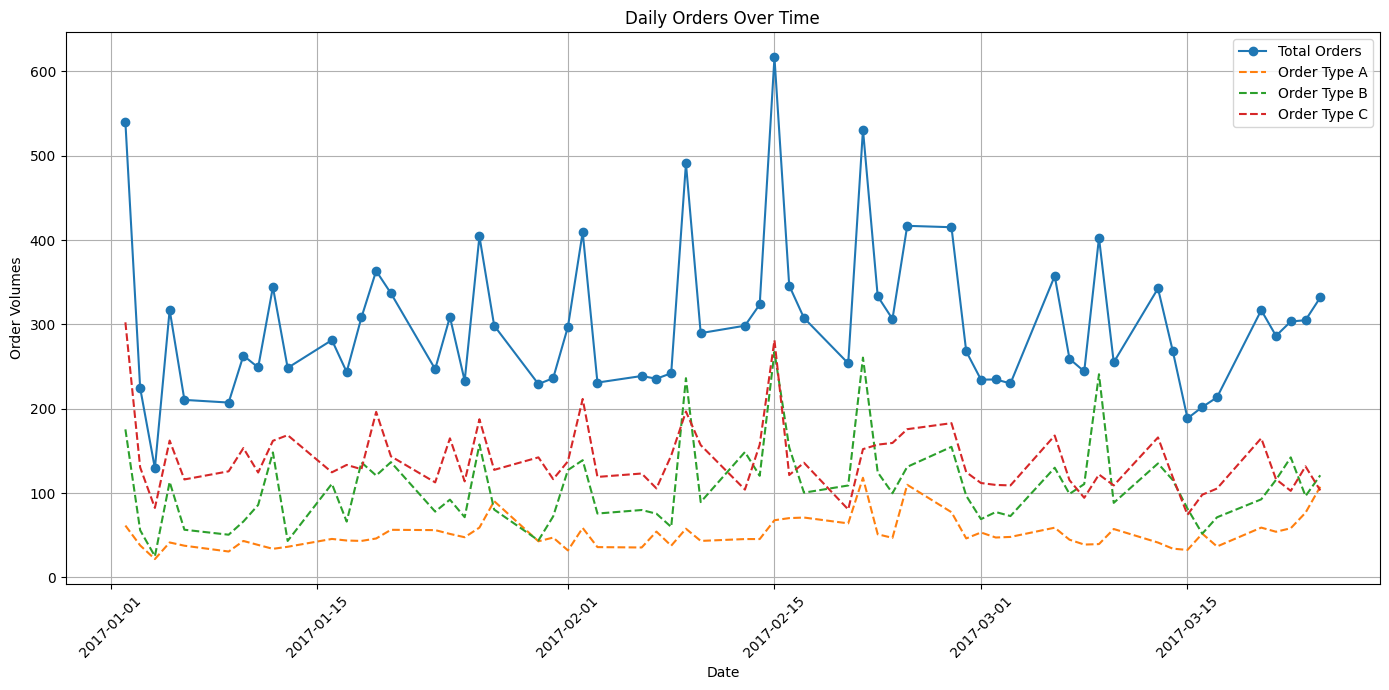

In [7]:
time_series = pd.date_range(start='2017-01-01', periods=len(data), freq='B')
data['Date'] = time_series

# Plotting orders over time
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Target (Total orders)'], marker='o', linestyle='-', label='Total Orders')
plt.plot(data['Date'], data['Order type A'], marker='', linestyle='--', label='Order Type A')
plt.plot(data['Date'], data['Order type B'], marker='', linestyle='--', label='Order Type B')
plt.plot(data['Date'], data['Order type C'], marker='', linestyle='--', label='Order Type C')

plt.title('Daily Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Order Volumes')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Aggregate data by week of the month and day of the week for each order type
pivot_a = data.pivot_table(values='Order type A', index='Week of the month',
                            columns='Day of the week', aggfunc='sum')

pivot_b = data.pivot_table(values='Order type B', index='Week of the month',
                            columns='Day of the week', aggfunc='sum')

pivot_c = data.pivot_table(values='Order type C', index='Week of the month',
                            columns='Day of the week', aggfunc='sum')

In [9]:
pivot_total = data.pivot_table(values='Target (Total orders)', index='Week of the month',
                            columns='Day of the week', aggfunc='sum')

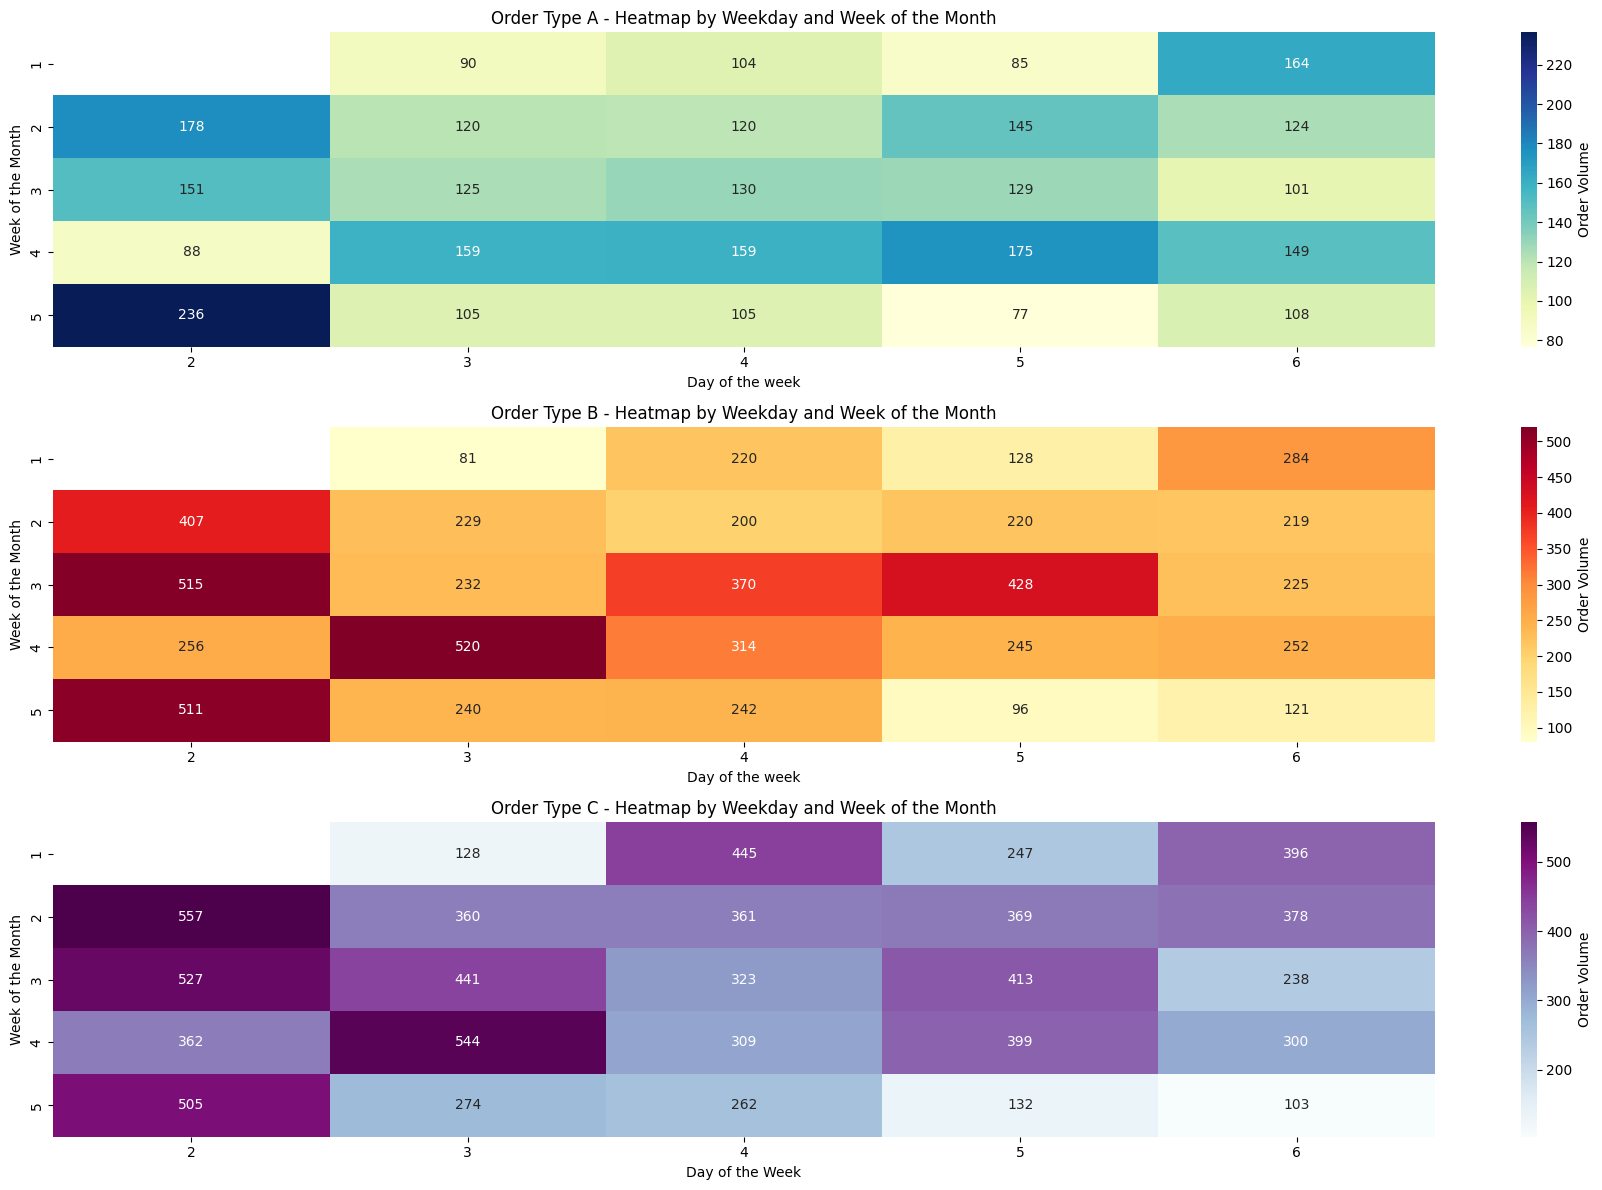

In [10]:
# Create heatmaps
plt.figure(figsize=(18, 12))
plt.subplot(3, 1, 1)
sns.heatmap(pivot_a, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Order Volume'})
plt.title('Order Type A - Heatmap by Weekday and Week of the Month')
plt.ylabel('Week of the Month')

plt.subplot(3, 1, 2)
sns.heatmap(pivot_b, annot=True, fmt=".0f", cmap="YlOrRd", cbar_kws={'label': 'Order Volume'})
plt.title('Order Type B - Heatmap by Weekday and Week of the Month')
plt.ylabel('Week of the Month')

plt.subplot(3, 1, 3)
sns.heatmap(pivot_c, annot=True, fmt=".0f", cmap="BuPu", cbar_kws={'label': 'Order Volume'})
plt.title('Order Type C - Heatmap by Weekday and Week of the Month')
plt.ylabel('Week of the Month')
plt.xlabel('Day of the Week')

plt.tight_layout()
plt.show()

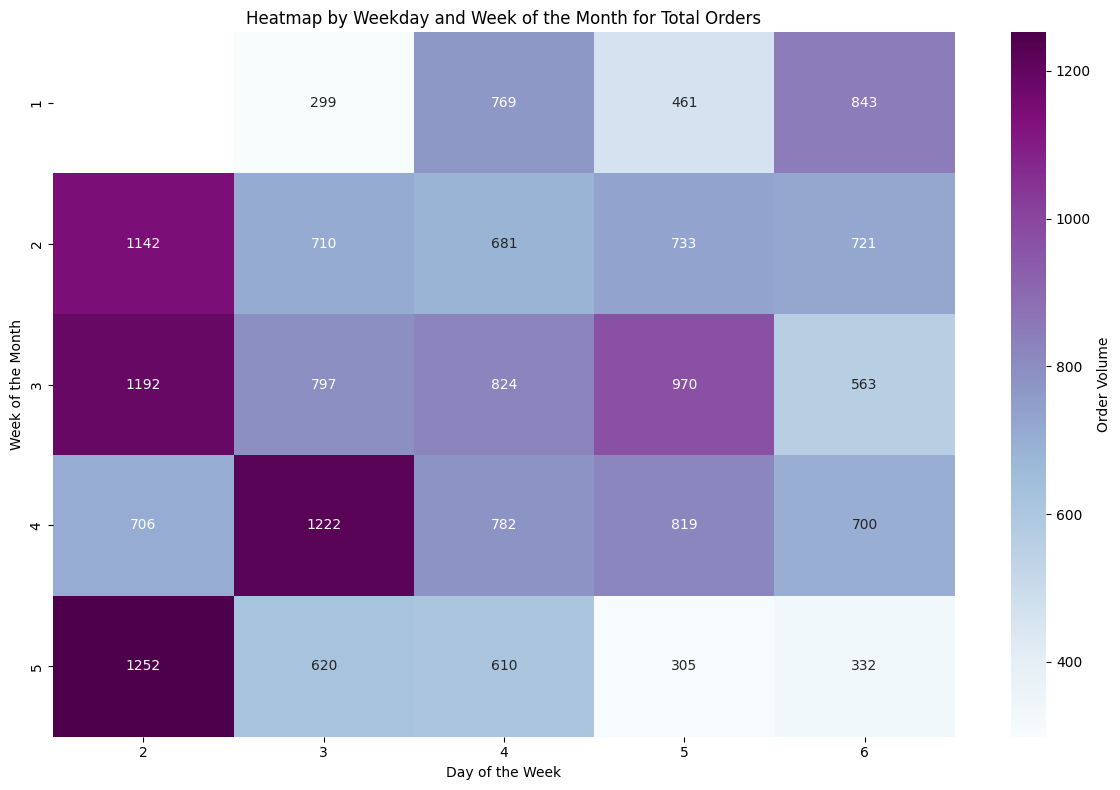

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_total, annot=True, fmt=".0f", cmap="BuPu", cbar_kws={'label': 'Order Volume'})
plt.title('Heatmap by Weekday and Week of the Month for Total Orders')
plt.ylabel('Week of the Month')
plt.xlabel('Day of the Week')

plt.tight_layout()
plt.show()

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure the data is sorted by date, which is essential for time series analysis
data_sorted = data.sort_values('Date')

# Set the frequency for the time series data; assuming 5 working days per week
data_sorted.set_index('Date', inplace=True)

# Performing the seasonal decomposition
decomposition = seasonal_decompose(data_sorted['Target (Total orders)'], model='additive', period=5)

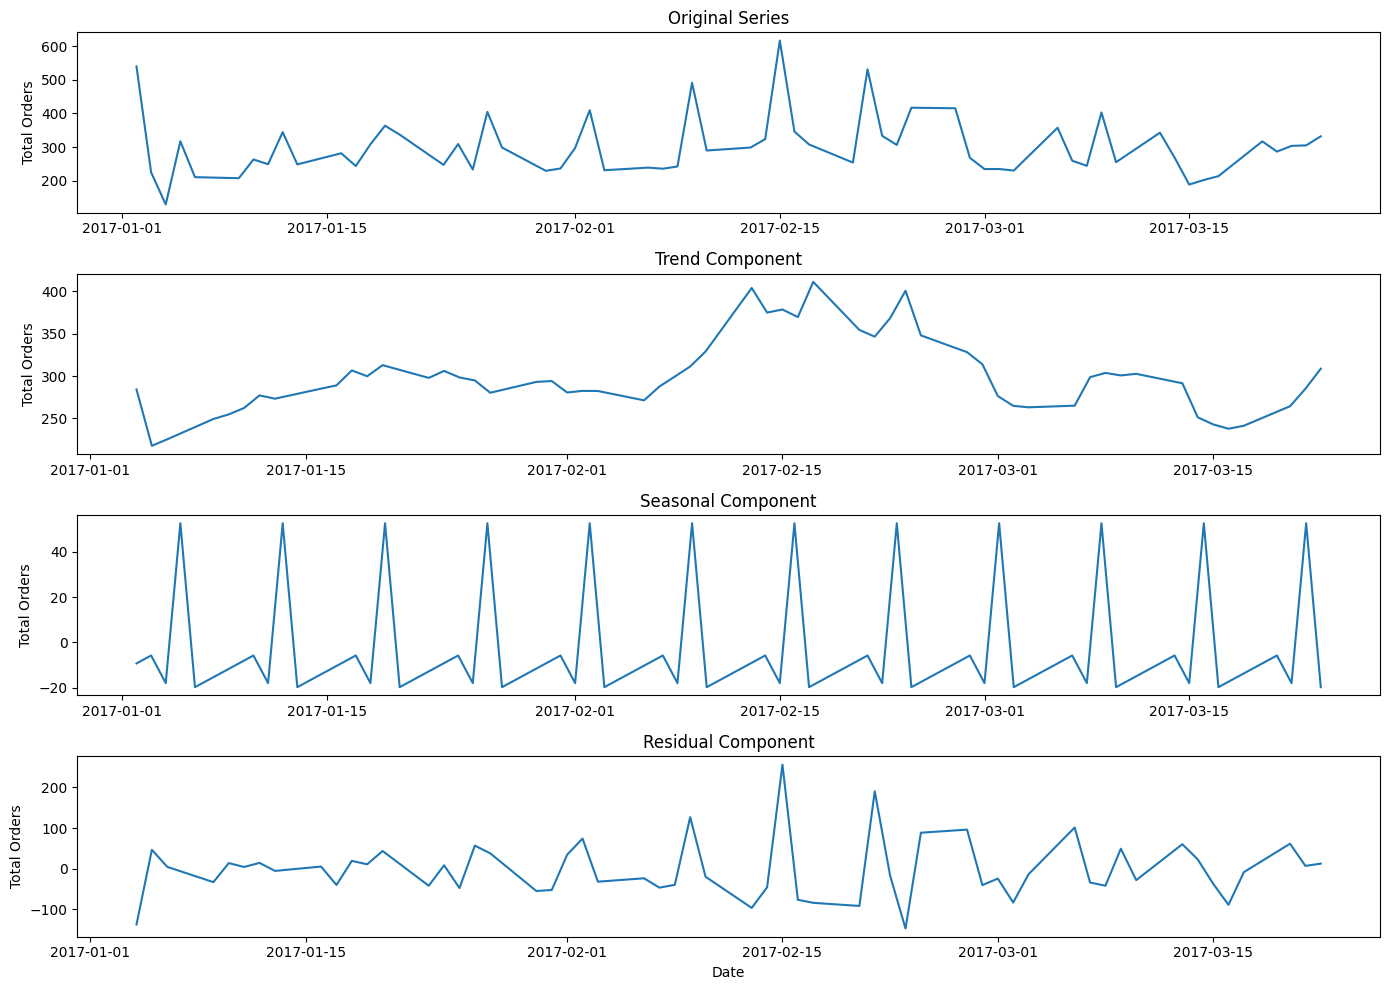

In [13]:
# Plotting the decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Original Series')
plt.ylabel('Total Orders')

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend Component')
plt.ylabel('Total Orders')

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')
plt.ylabel('Total Orders')

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual Component')
plt.ylabel('Total Orders')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

### Stationary

In [14]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(data_sorted['Target (Total orders)'].dropna())

# Extract and display the ADF test results
adf_statistic, adf_pvalue, usedlag, nobs, critical_values, icbest = adf_result
adf_result_summary = {
    "ADF Statistic": adf_statistic,
    "p-value": adf_pvalue,
    "Number of Observations Used": nobs,
    "Critical Values": critical_values
}

adf_result_summary

{'ADF Statistic': -7.494948804576737,
 'p-value': 4.404699295229799e-11,
 'Number of Observations Used': 59,
 'Critical Values': {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665}}

In [15]:
if adf_result_summary['p-value'] < 0.05:
    print('ADF test shows that the data is stationary.')
else:
    print('ADF test shows that the data is not stationary.')

ADF test shows that the data is stationary.


### Seasonality

<Figure size 1400x700 with 0 Axes>

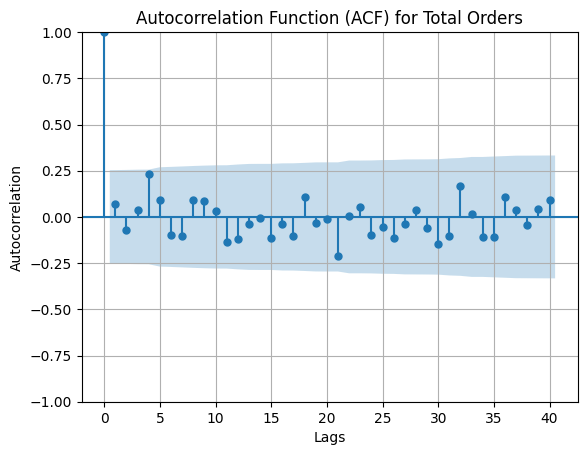

In [16]:
# Generate ACF plot to test for seasonality
plt.figure(figsize=(14, 7))
plot_acf(data_sorted['Target (Total orders)'], lags=40, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for Total Orders')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

The Autocorrelation Function (ACF) plot shows the correlation of the "Target (Total orders)" series with its own lagged values, up to 40 lags. Here's how to interpret the plot:

Significance: The blue shaded area represents the confidence interval (typically set at 95%). Any spike extending beyond this area is statistically significant, indicating that the autocorrelation at that lag is significantly different from zero.
Seasonal Lags: Looking for spikes at specific lags that repeatedly show significance can help identify the seasonality. For example, if there are significant spikes at every 5th lag (considering the dataset appears to follow a weekly cycle with 5 business days), it would confirm weekly seasonality.
In this ACF plot:

There are spikes that are significantly different from zero at multiple lags, including the initial lags, which suggests the presence of autocorrelation.
The pattern of these spikes may suggest a repeating cycle, supporting the presence of seasonality.

<Figure size 1400x700 with 0 Axes>

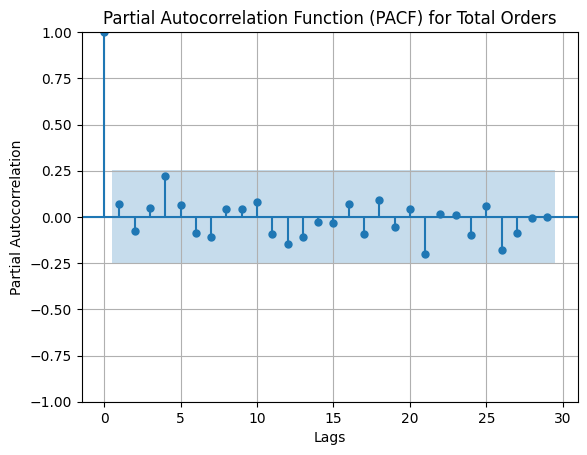

In [17]:
sample_size = len(data_sorted['Target (Total orders)'])
max_lags = sample_size // 2 - 1

plt.figure(figsize=(14, 7))
plot_pacf(data_sorted['Target (Total orders)'], lags=max_lags, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) for Total Orders')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

#### QS Test

In [18]:

# Compute the autocorrelation function
autocorr_values = acf(data_sorted['Target (Total orders)'].dropna(), nlags=40, fft=False)

# Define the seasonal lag (weekly cycle in days)
seasonal_lag = 5

# Number of seasons to include in the test (e.g., up to 40 days/5 = 8 weeks)
num_seasons = 40 // seasonal_lag

# Calculate the Q statistic for seasonality at the seasonal lag
n = len(data_sorted['Target (Total orders)'].dropna())
Q_statistic = n * np.sum(np.array(autocorr_values[seasonal_lag::seasonal_lag])**2)
Q_statistic, num_seasons

(3.9474161218097708, 8)

In [19]:
# Degrees of freedom is the number of seasons considered
degrees_of_freedom = num_seasons

# Calculate p-value from the chi-squared distribution
p_value = 1 - chi2.cdf(Q_statistic, degrees_of_freedom)
p_value

0.8618363065873933

In [20]:
if p_value < 0.05:
    print('There is enough evidence to reject the null hypothesis of no seasonality at the weekly lag for the "Target (Total orders)" time series')
else:
    print('There is not enough evidence to reject the null hypothesis of no seasonality at the weekly lag for the "Target (Total orders)" time series')

There is not enough evidence to reject the null hypothesis of no seasonality at the weekly lag for the "Target (Total orders)" time series


In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series data
decomposition = seasonal_decompose(data_sorted['Target (Total orders)'], model='additive', period=5)

# Extract the seasonal and residual components
seasonal_component = decomposition.seasonal
residual_component = decomposition.resid

# Calculate the variance of the seasonal component and the total variance (excluding NaN in residuals)
seasonal_variance = seasonal_component.var()
total_variance = data_sorted['Target (Total orders)'].var()

# Calculate the strength of seasonality
seasonality_strength = seasonal_variance / total_variance
seasonality_strength

0.09103450110769638

A value of 0.091 suggests that seasonality is present but not overwhelmingly dominant in the dataset. This moderate level of seasonality indicates that while seasonal patterns are an important factor in the data, other factors (like trend and irregular components) also play significant roles in determining the total order volumes.
This measure helps in understanding how much emphasis to place on seasonal adjustments when modeling or forecasting this time series.

## Analyze

In [22]:
# Prepare the data
data_series = data_sorted['Target (Total orders)'].values
train, test = train_test_split(data_series, test_size=0.2, shuffle=False)

# Store models and results
models_results = {}

In [23]:
# ARIMA Model: fitting a simple ARIMA model (parameters to be determined by AIC or other means)
arima_model = SARIMAX(train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0))
arima_fitted = arima_model.fit(disp=False)
arima_pred = arima_fitted.forecast(len(test))
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
models_results['ARIMA'] = arima_rmse

In [24]:
# SARIMA Model: fitting with assumed seasonal order
sarima_model = SARIMAX(train, order=(0, 0, 0), seasonal_order=(1, 0, 1, 5))
sarima_fitted = sarima_model.fit(disp=False)
sarima_pred = sarima_fitted.forecast(len(test))
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_pred))
models_results['SARIMA'] = sarima_rmse

In [25]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# Prepare data for RF (lag features, because RF cannot handle raw sequence data directly)
X = np.array([train[i:i+5] for i in range(len(train)-5)])
y = train[5:]
rf_model.fit(X, y)
X_test = np.array([test[i:i+5] for i in range(len(test)-5)])
rf_pred = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(test[5:], rf_pred))
models_results['Random Forest'] = rf_rmse

In [26]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(5, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
# Prepare data for LSTM (reshape for LSTM [samples, timesteps, features])
X_lstm = np.array([train[i:i+5] for i in range(len(train)-5)])
y_lstm = train[5:]
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))
X_test_lstm = np.array([test[i:i+5] for i in range(len(test)-5)])
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))
lstm_model.fit(X_lstm, y_lstm, epochs=50, verbose=0)
lstm_pred = lstm_model.predict(X_test_lstm).flatten()
lstm_rmse = np.sqrt(mean_squared_error(test[5:], lstm_pred))
models_results['LSTM'] = lstm_rmse

/Users/pyc/miniconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 1/100


/Users/pyc/miniconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 - 0s - 12ms/step - loss: 0.0688
Epoch 2/100
22/22 - 0s - 786us/step - loss: 0.0433
Epoch 3/100
22/22 - 0s - 784us/step - loss: 0.0360
Epoch 4/100
22/22 - 0s - 778us/step - loss: 0.0351
Epoch 5/100
22/22 - 0s - 739us/step - loss: 0.0350
Epoch 6/100
22/22 - 0s - 731us/step - loss: 0.0338
Epoch 7/100
22/22 - 0s - 713us/step - loss: 0.0334
Epoch 8/100
22/22 - 0s - 765us/step - loss: 0.0324
Epoch 9/100
22/22 - 0s - 745us/step - loss: 0.0320
Epoch 10/100
22/22 - 0s - 718us/step - loss: 0.0317
Epoch 11/100
22/22 - 0s - 730us/step - loss: 0.0315
Epoch 12/100
22/22 - 0s - 719us/step - loss: 0.0313
Epoch 13/100
22/22 - 0s - 728us/step - loss: 0.0316
Epoch 14/100
22/22 - 0s - 748us/step - loss: 0.0308
Epoch 15/100
22/22 - 0s - 723us/step - loss: 0.0304
Epoch 16/100
22/22 - 0s - 726us/step - loss: 0.0305
Epoch 17/100
22/22 - 0s - 741us/step - loss: 0.0303
Epoch 18/100
22/22 - 0s - 725us/step - loss: 0.0298
Epoch 19/100
22/22 - 0s - 746us/step - loss: 0.0298
Epoch 20/100
22/22 - 0s - 734us/st

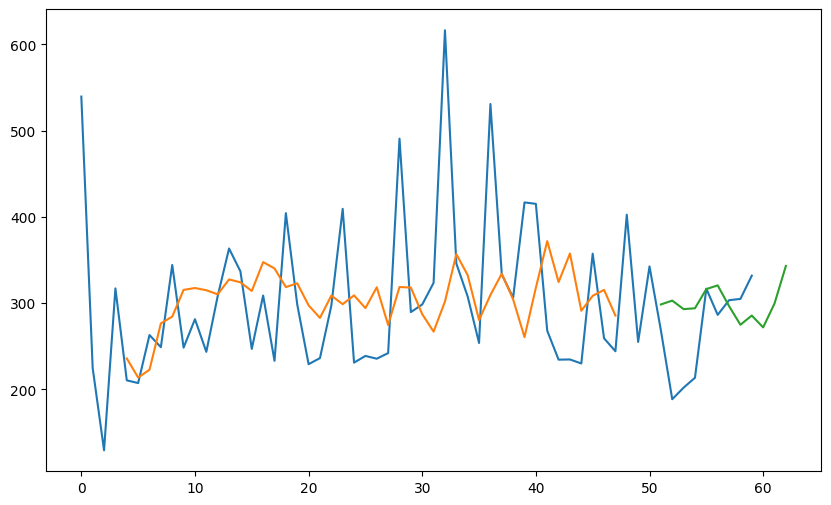

In [27]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_series.reshape(-1, 1))

# Function to create dataset for supervised learning
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Specify the number of lag observations to use as input features
look_back = 3
X, Y = create_dataset(data_scaled, look_back)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, trainY = X[:train_size], Y[:train_size]
testX, testY = X[train_size:], Y[train_size:]

# Create and train the DNN model
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=2, verbose=2)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate and print RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')
models_results['DNN'] = testScore

# Plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(data_scaled))
plt.plot(np.arange(look_back + 1, len(trainPredict) + look_back + 1), trainPredict)
plt.plot(np.arange(len(trainPredict) + (look_back * 2) + 1, len(trainPredict) + len(testPredict) + (look_back * 2) + 1), testPredict)
plt.show()

Epoch 1/100


/Users/pyc/miniconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 - 0s - 138ms/step - loss: 0.2361 - val_loss: 0.1308
Epoch 2/100
3/3 - 0s - 7ms/step - loss: 0.1426 - val_loss: 0.0516
Epoch 3/100
3/3 - 0s - 7ms/step - loss: 0.0801 - val_loss: 0.0277
Epoch 4/100
3/3 - 0s - 10ms/step - loss: 0.0455 - val_loss: 0.0445
Epoch 5/100
3/3 - 0s - 7ms/step - loss: 0.0344 - val_loss: 0.0825
Epoch 6/100
3/3 - 0s - 7ms/step - loss: 0.0386 - val_loss: 0.1199
Epoch 7/100
3/3 - 0s - 7ms/step - loss: 0.0554 - val_loss: 0.1338
Epoch 8/100
3/3 - 0s - 7ms/step - loss: 0.0365 - val_loss: 0.1184
Epoch 9/100
3/3 - 0s - 7ms/step - loss: 0.0412 - val_loss: 0.0987
Epoch 10/100
3/3 - 0s - 7ms/step - loss: 0.0414 - val_loss: 0.0792
Epoch 11/100
3/3 - 0s - 7ms/step - loss: 0.0365 - val_loss: 0.0678
Epoch 12/100
3/3 - 0s - 7ms/step - loss: 0.0351 - val_loss: 0.0594
Epoch 13/100
3/3 - 0s - 7ms/step - loss: 0.0335 - val_loss: 0.0589
Epoch 14/100
3/3 - 0s - 8ms/step - loss: 0.0381 - val_loss: 0.0593
Epoch 15/100
3/3 - 0s - 8ms/step - loss: 0.0373 - val_loss: 0.0594
Epoch 16/100


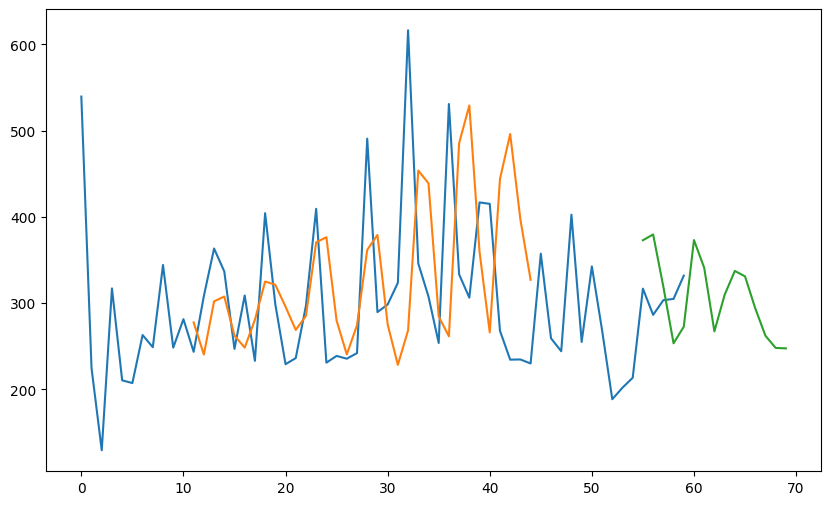

In [28]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_series.reshape(-1, 1))

# Reshape into X=t and Y=t+1
look_back = 10  # Number of time steps to look back 
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X, Y = create_dataset(data_scaled, look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape input to be [samples, time steps, features]

# Split into train and test sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = Y[:train_size], Y[train_size:]

# Create the CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))  # Another Dropout layer
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit model with early stopping
model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=2, validation_split=0.2) # , callbacks=[early_stopping]

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
models_results['CNN-LSTM'] = testScore

# Plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(data_scaled))
plt.plot(np.arange(look_back + 1, len(trainPredict) + look_back + 1), trainPredict)
plt.plot(np.arange(len(trainPredict) + (look_back * 2) + 1, len(trainPredict) + len(testPredict) + (look_back * 2) + 1), testPredict)
plt.show()

In [29]:
models_results

{'ARIMA': 291.02140050547257,
 'SARIMA': 61.34019116947644,
 'Random Forest': 62.58589980585814,
 'LSTM': 47.22155928111714,
 'DNN': 65.67820686311906,
 'CNN-LSTM': 85.51020699750762}

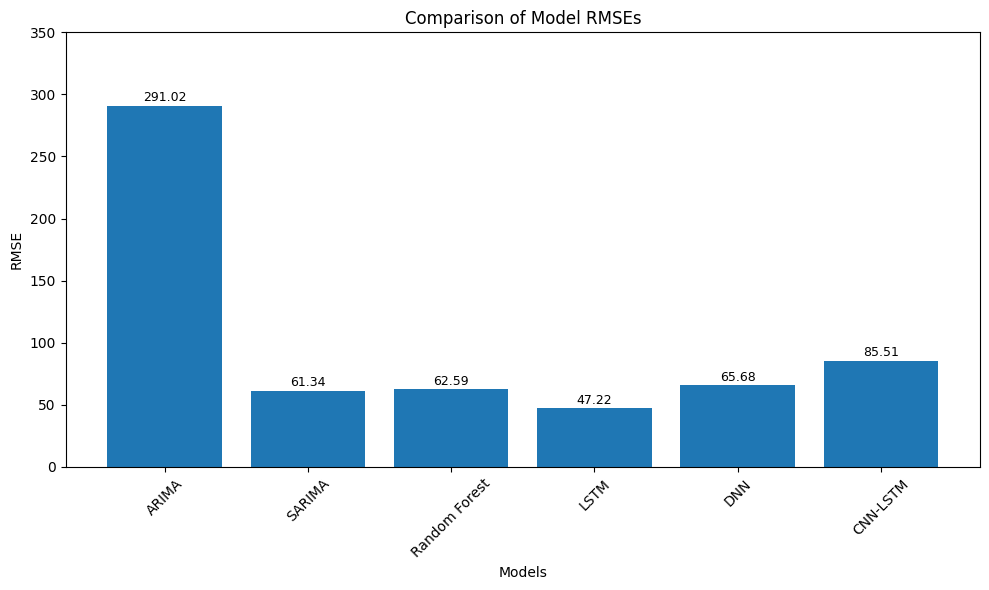

In [30]:
# Names of models
models = list(models_results.keys())

# Corresponding RMSE values
rmse_values = list(models_results.values())

# Normalizing RMSE values to use for color mapping
norm = plt.Normalize(min(rmse_values), max(rmse_values))
colors = plt.cm.viridis(norm(rmse_values))  # Using the 'viridis' colormap

# Creating the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, rmse_values, color=colors)
plt.bar(models, rmse_values)
plt.ylim (0, 350)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of Model RMSEs')
plt.xticks(rotation=45)
# add data label
for bar, value in zip(bars, rmse_values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show the plot
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


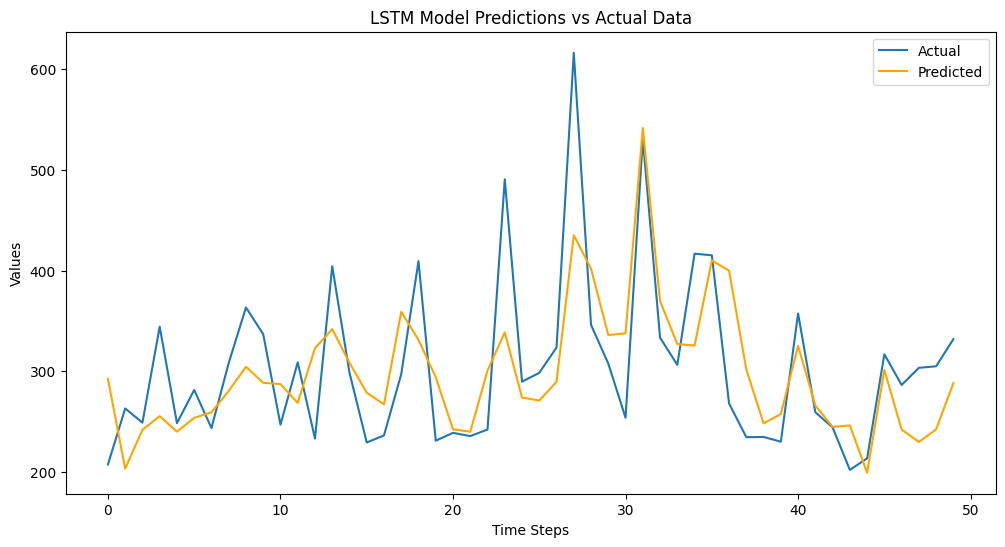

In [31]:
# Generate predictions for training data
train_pred = lstm_model.predict(X_lstm).flatten()

# Prepare actual data (excluding the first 5 used for initial sequence)
actual_train = train[5:len(train_pred)+5]
actual_test = test[5:len(lstm_pred)+5]

# Combine predictions and actual data for plotting
combined_pred = np.concatenate((train_pred, lstm_pred))
combined_actual = np.concatenate((actual_train, actual_test))

# Create time index for plotting
time_steps = np.arange(len(combined_pred))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_steps, combined_actual, label='Actual')
plt.plot(time_steps, combined_pred, label='Predicted', color='orange')
plt.title('LSTM Model Predictions vs Actual Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()